In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend, regularizers, initializers, models
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [26]:
cifar100 = keras.datasets.cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print("x_train:", len(x_train), "x_test:", len(x_test))

x_train: 50000 x_test: 10000


In [27]:
def conv_block(input_tensor,
                     filters,
                     stage,
                     block,
                     strides=(2,2),
                     bn_decay=0.9,
                     bn_epsilon=1e-5):
  
  filters1,filters2,filters3=filters

  if backend.image_data_format()=='channels_last':
    bn_axis=3
  else:
    bn_axis=1

  conv_name = 'res'+str(stage)+block+'_branch'
  bn_name = 'bn'+str(stage)+block+'_branch'

  x = layers.Conv2D(filters1,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=conv_name+'2a')(input_tensor)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2a')(x)
  
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters2,(3,3),strides=strides,padding='same',use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=conv_name+'2b')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2b')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters3,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=conv_name+'2c')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2c')(x)

  shortcut = layers.Conv2D(filters3,(1,1),strides=strides,use_bias=False,
                           kernel_initializer='he_normal',
                           kernel_regularizer=keras.regularizers.l2(1e-4),
                           name=conv_name+'1')(input_tensor)

  shortcut = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'1')(shortcut)

  x = layers.add([shortcut,x])
  
  x = layers.Activation('relu')(x)

  return x

In [28]:
def identity_block(input_tensor,
                         filters,
                         stage,
                         block,
                         bn_decay=0.9,
                         bn_epsilon=1e-5):
  
  filters1,filters2,filters3=filters

  if backend.image_data_format()=='channels_last':
    bn_axis=3
  else:
    bn_axis=1

  id_name='res'+str(stage)+block+'_barnch'
  bn_name='bn'+str(stage)+block+'_barnch'

  x = layers.Conv2D(filters1,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=id_name+'2a')(input_tensor)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2a')(x)
  
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters2,(3,3),padding='same',use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=id_name+'2b')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2b')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters3,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=id_name+'2c')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2c')(x)

  x = layers.add([x,input_tensor])

  x = layers.Activation('relu')(x)

  return x

In [29]:
def ResNet101(num_classes,
              batch_size=None,
              bn_decay=0.9,
              bn_epsilon=1e-5):
  
  input_shape = (32,32,3)
  input=layers.Input(shape=input_shape, batch_size=batch_size)

  if backend.image_data_format == 'channels_last':
    bn_axis=3
    x = input
  else:
    x = layers.Permute((3, 1, 2))(input)
    bn_axis=1

  config_block=dict(bn_decay=bn_decay,
               bn_epsilon=bn_epsilon)
  
  x = layers.ZeroPadding2D(padding=(3,3),name='conv_pad')(x)
  x = layers.Conv2D(64,(7,7),strides=(2,2),padding='valid',use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name='conv1')(x)
  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name='bn1')(x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D((3,3),strides=(2,2),padding='same')(x)

  x = conv_block(x,[64,64,256],stage=2,block='a',strides=(1,1),**config_block)
  x = identity_block(x,[64,64,256],stage=2,block='b',**config_block)
  x = identity_block(x,[64,64,256],stage=2,block='c',**config_block)

  x = conv_block(x,[128,128,512],stage=3,block='a',**config_block)
  x = identity_block(x,[128,128,512],stage=3,block='b',**config_block)
  x = identity_block(x,[128,128,512],stage=3,block='c',**config_block)
  x = identity_block(x,[128,128,512],stage=3,block='d',**config_block)

  x = conv_block(x,[256,256,1024],stage=4,block='a',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='b',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='c',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='d',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='e',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='f',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='g',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='h',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='i',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='j',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='k',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='l',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='m',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='n',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='o',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='p',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='q',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='r',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='t',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='u',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='v',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='w',**config_block)
  x = identity_block(x,[256,256,1024],stage=4,block='x',**config_block)

  x = conv_block(x,[512,512,2048],stage=5,block='a',**config_block)
  x = identity_block(x,[512,512,2048],stage=5,block='b',**config_block)
  x = identity_block(x,[512,512,2048],stage=5,block='c',**config_block)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(num_classes,
                   kernel_initializer=initializers.RandomNormal(stddev=0.01),
                   kernel_regularizer=keras.regularizers.l2(1e-4),
                   bias_regularizer=keras.regularizers.l2(1e-4),
                   name='fc1000')(x)
  x = layers.Activation('softmax',dtype='float32')(x)

  return models.Model(input,x,name='Plain101')

In [30]:
resnet101 = ResNet101(num_classes=100)
resnet101.summary()

Model: "Plain101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 permute_3 (Permute)            (None, 3, 32, 32)    0           ['input_4[0][0]']                
                                                                                                  
 conv_pad (ZeroPadding2D)       (None, 9, 38, 32)    0           ['permute_3[0][0]']              
                                                                                                  
 conv1 (Conv2D)                 (None, 2, 16, 64)    100352      ['conv_pad[0][0]']               
                                                                                           

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.871718 to fit



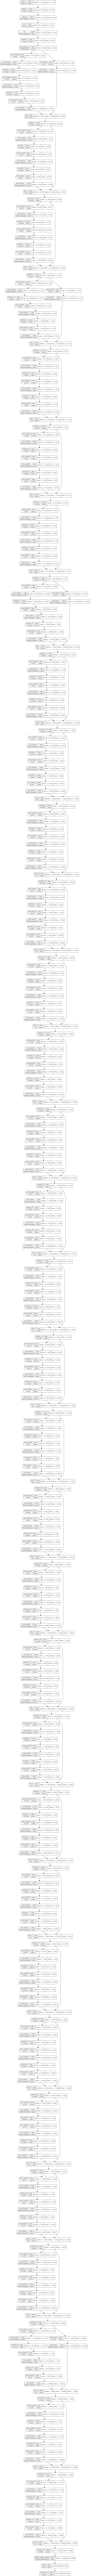

In [31]:
plot_model(resnet101,show_shapes=True)

In [32]:
resnet101.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_resnet101 = resnet101.fit(x_train, y_train, epochs=100)

Epoch 1/100
1563/1563 [==============================] - 148s 80ms/step - loss: 15.1860 - accuracy: 0.0416
Epoch 2/100
1563/1563 [==============================] - 123s 79ms/step - loss: 14.7366 - accuracy: 0.0732
Epoch 3/100
1563/1563 [==============================] - 123s 79ms/step - loss: 14.4730 - accuracy: 0.0957
Epoch 4/100
1563/1563 [==============================] - 124s 79ms/step - loss: 14.2699 - accuracy: 0.1184
Epoch 5/100
1563/1563 [==============================] - 122s 78ms/step - loss: 14.1055 - accuracy: 0.1344
Epoch 6/100
1563/1563 [==============================] - 121s 78ms/step - loss: 13.9560 - accuracy: 0.1482
Epoch 7/100
1563/1563 [==============================] - 121s 78ms/step - loss: 13.8110 - accuracy: 0.1624
Epoch 8/100
1563/1563 [==============================] - 122s 78ms/step - loss: 13.6735 - accuracy: 0.1759
Epoch 9/100
1563/1563 [==============================] - 121s 78ms/step - loss: 13.5472 - accuracy: 0.1845
Epoch 10/100
1563/1563 [=============

In [33]:
#BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3)
def dense_block(input_tensor,
                filters,
                stage,
                block,
                bn_decay=0.9,
                bn_epsilon=1e-5):
  filters1,filters2=filters

  if backend.image_data_format() == 'channels_last':
    bn_axis=3
  else:
    bn_axis=1

  dense_name='dense'+str(stage)+block+'_branch'
  bn_name='bn'+str(stage)+block+'_branch'

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2a')(input_tensor)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters1,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=dense_name+'2a')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2b')(x)
  
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters2,(3,3),padding='same',use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=dense_name+'2b')(x)

  x = layers.concatenate([x,input_tensor])

  return x

In [34]:
#BN → 1×1 convolutional layer → 2×2 average pooling layer
def transition_block(input_tensor,
                     filters,
                     stage,
                     block,
                     bn_decay=0.9,
                     bn_epsilon=1e-5):
  if backend.image_data_format() == 'channels_last':
    bn_axis=3
  else:
    bn_axis=1

  transition_name = 'transition'+str(stage)+block+'_branch'
  bn_name='bn'+str(stage)+block+'_branch'

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2a')(input_tensor)

  x = layers.Conv2D(filters,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=transition_name+'2a')(x)

  x = layers.AveragePooling2D(pool_size=(2,2),strides=(2,2),padding='same')(x)

  return x

In [35]:
def DenseNet121(num_classes,
                batch_size=None,
                bn_decay=0.9,
                bn_epsilon=1e-5):
  
  input_shape=(32,32,3)
  input = layers.Input(shape=input_shape,batch_size=batch_size)

  if backend.image_data_format() == 'channels_last':
    bn_axis=3
    x = input
  else:
    x = layers.permute((3,1,2))(input)
    bn_axis=1

  config_block=dict(bn_decay=bn_decay,
                    bn_epsilon=bn_epsilon)
  x = layers.Conv2D(64,(7,7),strides=(2,2),padding='same',
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name='conv1')(x)

  x = layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

  x = dense_block(x,[128,32],stage=2,block='a',**config_block)
  x = dense_block(x,[128,32],stage=2,block='b',**config_block)
  x = dense_block(x,[128,32],stage=2,block='c',**config_block)
  x = dense_block(x,[128,32],stage=2,block='d',**config_block)
  x = dense_block(x,[128,32],stage=2,block='e',**config_block)
  x = dense_block(x,[128,32],stage=2,block='f',**config_block)
  x = transition_block(x,32,stage=2,block='g',**config_block)

  x = dense_block(x,[128,32],stage=3,block='a',**config_block)
  x = dense_block(x,[128,32],stage=3,block='b',**config_block)
  x = dense_block(x,[128,32],stage=3,block='c',**config_block)
  x = dense_block(x,[128,32],stage=3,block='d',**config_block)
  x = dense_block(x,[128,32],stage=3,block='e',**config_block)
  x = dense_block(x,[128,32],stage=3,block='f',**config_block)
  x = dense_block(x,[128,32],stage=3,block='g',**config_block)
  x = dense_block(x,[128,32],stage=3,block='h',**config_block)
  x = dense_block(x,[128,32],stage=3,block='i',**config_block)
  x = dense_block(x,[128,32],stage=3,block='j',**config_block)
  x = dense_block(x,[128,32],stage=3,block='k',**config_block)
  x = dense_block(x,[128,32],stage=3,block='l',**config_block)
  x = transition_block(x,32,stage=3,block='m',**config_block)

  x = dense_block(x,[128,32],stage=4,block='a',**config_block)
  x = dense_block(x,[128,32],stage=4,block='b',**config_block)
  x = dense_block(x,[128,32],stage=4,block='c',**config_block)
  x = dense_block(x,[128,32],stage=4,block='d',**config_block)
  x = dense_block(x,[128,32],stage=4,block='e',**config_block)
  x = dense_block(x,[128,32],stage=4,block='f',**config_block)
  x = dense_block(x,[128,32],stage=4,block='g',**config_block)
  x = dense_block(x,[128,32],stage=4,block='h',**config_block)
  x = dense_block(x,[128,32],stage=4,block='i',**config_block)
  x = dense_block(x,[128,32],stage=4,block='j',**config_block)
  x = dense_block(x,[128,32],stage=4,block='k',**config_block)
  x = dense_block(x,[128,32],stage=4,block='l',**config_block)
  x = dense_block(x,[128,32],stage=4,block='m',**config_block)
  x = dense_block(x,[128,32],stage=4,block='n',**config_block)
  x = dense_block(x,[128,32],stage=4,block='o',**config_block)
  x = dense_block(x,[128,32],stage=4,block='p',**config_block)
  x = dense_block(x,[128,32],stage=4,block='q',**config_block)
  x = dense_block(x,[128,32],stage=4,block='r',**config_block)
  x = dense_block(x,[128,32],stage=4,block='s',**config_block)
  x = dense_block(x,[128,32],stage=4,block='t',**config_block)
  x = dense_block(x,[128,32],stage=4,block='u',**config_block)
  x = dense_block(x,[128,32],stage=4,block='v',**config_block)
  x = dense_block(x,[128,32],stage=4,block='w',**config_block)
  x = dense_block(x,[128,32],stage=4,block='x',**config_block)
  x = transition_block(x,32,stage=4,block='y',**config_block)

  x = dense_block(x,[128,32],stage=5,block='a',**config_block)
  x = dense_block(x,[128,32],stage=5,block='b',**config_block)
  x = dense_block(x,[128,32],stage=5,block='c',**config_block)
  x = dense_block(x,[128,32],stage=5,block='d',**config_block)
  x = dense_block(x,[128,32],stage=5,block='e',**config_block)
  x = dense_block(x,[128,32],stage=5,block='f',**config_block)
  x = dense_block(x,[128,32],stage=5,block='g',**config_block)
  x = dense_block(x,[128,32],stage=5,block='h',**config_block)
  x = dense_block(x,[128,32],stage=5,block='i',**config_block)
  x = dense_block(x,[128,32],stage=5,block='j',**config_block)
  x = dense_block(x,[128,32],stage=5,block='k',**config_block)
  x = dense_block(x,[128,32],stage=5,block='l',**config_block)
  x = dense_block(x,[128,32],stage=5,block='m',**config_block)
  x = dense_block(x,[128,32],stage=5,block='n',**config_block)
  x = dense_block(x,[128,32],stage=5,block='o',**config_block)
  x = dense_block(x,[128,32],stage=5,block='p',**config_block)
  x = transition_block(x,32,stage=5,block='q',**config_block)
  
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(
      num_classes,
      kernel_initializer='he_normal',
      kernel_regularizer=keras.regularizers.l2(1e-4),
      bias_regularizer=keras.regularizers.l2(1e-4),
      name='1000D_full')(x)
  x = layers.Activation('softmax',dtype='float32')(x)

  return models.Model(input,x,name='DenseNet121')

In [36]:
densenet121=DenseNet121(num_classes=100)
densenet121.summary()

Model: "DenseNet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   9472        ['input_5[0][0]']                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 8, 8, 64)    0           ['conv1[0][0]']                  
                                                                                                  
 bn2a_branch2a (BatchNormalizat  (None, 8, 8, 64)    256         ['max_pooling2d_4[0][0]']        
 ion)                                                                                   

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.69888 to fit



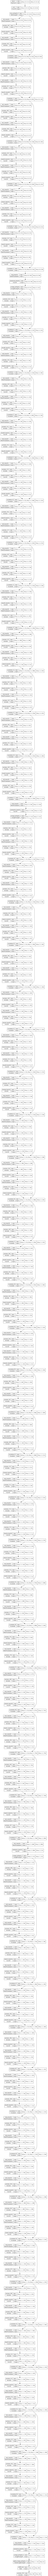

In [37]:
plot_model(densenet121,show_shapes=True)

In [38]:
densenet121.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_densenet121 = densenet121.fit(x_train, y_train, epochs=100)

Epoch 1/100
1563/1563 [==============================] - 137s 79ms/step - loss: 6.3512 - accuracy: 0.0528
Epoch 2/100
1563/1563 [==============================] - 123s 78ms/step - loss: 5.9318 - accuracy: 0.0979
Epoch 3/100
1563/1563 [==============================] - 121s 78ms/step - loss: 5.6772 - accuracy: 0.1299
Epoch 4/100
1563/1563 [==============================] - 121s 77ms/step - loss: 5.4839 - accuracy: 0.1554
Epoch 5/100
1563/1563 [==============================] - 122s 78ms/step - loss: 5.3091 - accuracy: 0.1843
Epoch 6/100
1563/1563 [==============================] - 121s 78ms/step - loss: 5.1540 - accuracy: 0.2066
Epoch 7/100
1563/1563 [==============================] - 121s 77ms/step - loss: 4.9969 - accuracy: 0.2308
Epoch 8/100
1563/1563 [==============================] - 122s 78ms/step - loss: 4.8486 - accuracy: 0.2544
Epoch 9/100
1563/1563 [==============================] - 121s 77ms/step - loss: 4.7119 - accuracy: 0.2776
Epoch 10/100
1563/1563 [======================

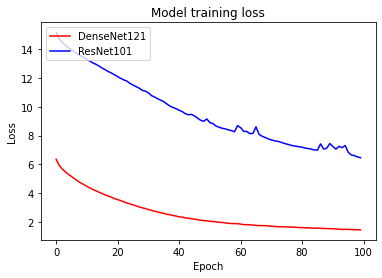

In [39]:
import matplotlib.pyplot as plt

plt.plot(history_densenet121.history['loss'],'r')
plt.plot(history_resnet101.history['loss'],'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['DenseNet121','ResNet101'], loc='upper left')
plt.show()

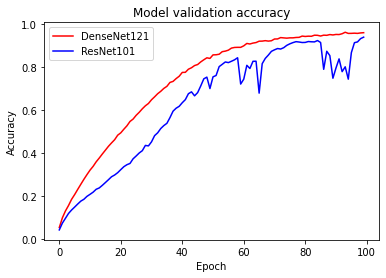

In [40]:
plt.plot(history_densenet121.history['accuracy'], 'r')
plt.plot(history_resnet101.history['accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['DenseNet121', 'ResNet101'], loc='upper left')
plt.show()